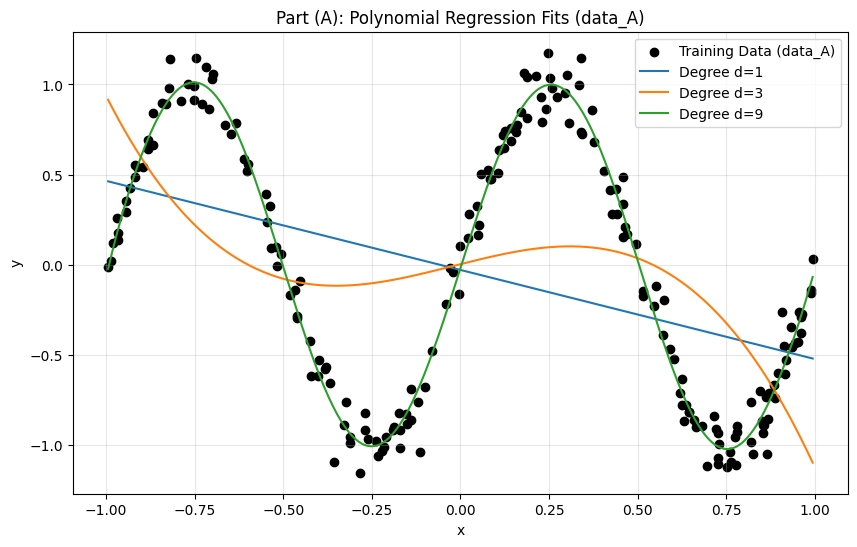

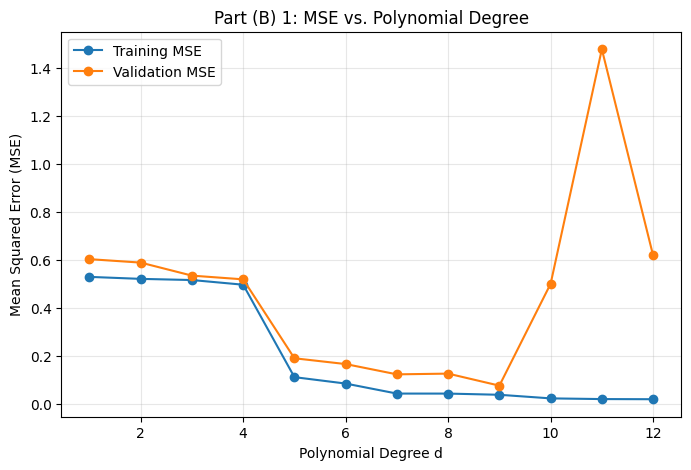

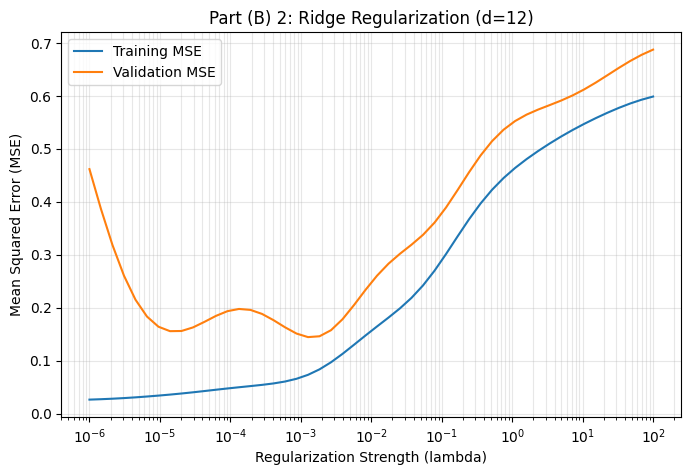

In [6]:
# question 4
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def get_design_matrix(x, degree):
    return np.column_stack([x**i for i in range(degree + 1)])

def solve_normal_equation(X, y, lmbda=0):
    n_features = X.shape[1]
    identity = np.eye(n_features)
    # normal equation
    theta = np.linalg.inv(X.T @ X + lmbda * identity) @ X.T @ y
    return theta

# A
data_A = pd.read_csv('data_A.csv')
x_A, y_A = data_A['x'].values, data_A['y'].values
degrees_A = [1, 3, 9]

plt.figure(figsize=(10, 6))
plt.scatter(x_A, y_A, color='black', label='Training Data (data_A)')

z_grid = np.linspace(min(x_A), max(x_A), 500)

for d in degrees_A:
    X_A = get_design_matrix(x_A, d)
    theta = solve_normal_equation(X_A, y_A)

    # compute curve
    Z_grid = get_design_matrix(z_grid, d)
    plt.plot(z_grid, Z_grid @ theta, label=f'Degree d={d}')

plt.title("Part (A): Polynomial Regression Fits (data_A)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# B
train_B = pd.read_csv('data_B_train.csv')
val_B = pd.read_csv('data_B_val.csv')

x_train, y_train = train_B['x'].values, train_B['y'].values
x_val, y_val = val_B['x'].values, val_B['y'].values

# polynomial degree
train_mses = []
val_mses = []
degrees_B = range(1, 13)

for d in degrees_B:
    X_tr = get_design_matrix(x_train, d)
    X_v = get_design_matrix(x_val, d)

    theta = solve_normal_equation(X_tr, y_train)

    train_mses.append(np.mean((X_tr @ theta - y_train)**2))
    val_mses.append(np.mean((X_v @ theta - y_val)**2))

plt.figure(figsize=(8, 5))
plt.plot(degrees_B, train_mses, marker='o', label='Training MSE')
plt.plot(degrees_B, val_mses, marker='o', label='Validation MSE')
plt.xlabel('Polynomial Degree d')
plt.ylabel('Mean Squared Error (MSE)')
plt.title("Part (B) 1: MSE vs. Polynomial Degree")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# d=12 allows us to observe how ridge controls high-degree complexity.
lambdas = np.logspace(-6, 2, 50) # 50 values log-spaced
ridge_train_mses = []
ridge_val_mses = []
d_fixed = 12

X_tr_r = get_design_matrix(x_train, d_fixed)
X_v_r = get_design_matrix(x_val, d_fixed)

for l in lambdas:
    theta_l = solve_normal_equation(X_tr_r, y_train, lmbda=l)

    ridge_train_mses.append(np.mean((X_tr_r @ theta_l - y_train)**2))
    ridge_val_mses.append(np.mean((X_v_r @ theta_l - y_val)**2))

plt.figure(figsize=(8, 5))
plt.semilogx(lambdas, ridge_train_mses, label='Training MSE') # Logarithmic scale on lambda
plt.semilogx(lambdas, ridge_val_mses, label='Validation MSE')
plt.xlabel('Regularization Strength (lambda)')
plt.ylabel('Mean Squared Error (MSE)')
plt.title("Part (B) 2: Ridge Regularization (d=12)")
plt.legend()
plt.grid(True, which="both", alpha=0.3)
plt.show()

In [1]:
# question 10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import ssl

from torchvision import models
ssl._create_default_https_context = ssl._create_unverified_context

# pre processing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=512, shuffle=False)

# MLP
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.main(x)

# VGG
def get_vgg(frozen=True):
    model = models.vgg11(weights='IMAGENET1K_V1')
    if frozen:
        for param in model.features.parameters():
            param.requires_grad = False
    model.classifier[6] = nn.Linear(4096, 10) # replace for 10 classes
    return model

def train_model(model, name, epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

    stats = {'loss': [], 'acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # val acc
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in valloader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        stats['loss'].append(running_loss/len(trainloader))
        stats['acc'].append(acc)
        print(f"{name} - Epoch {epoch+1}: Loss {stats['loss'][-1]:.4f}, Acc {acc:.2f}%")
    return stats

# exe
results_mlp = train_model(MLP(), "MLP")
results_frozen = train_model(get_vgg(frozen=True), "Frozen VGG")
results_finetune = train_model(get_vgg(frozen=False), "Fine-Tuned VGG")

100%|██████████| 170M/170M [03:31<00:00, 807kB/s]  


MLP - Epoch 1: Loss 1.6687, Acc 45.82%
MLP - Epoch 2: Loss 1.4317, Acc 49.84%
MLP - Epoch 3: Loss 1.3040, Acc 51.33%
MLP - Epoch 4: Loss 1.2075, Acc 52.69%
MLP - Epoch 5: Loss 1.1213, Acc 53.13%
MLP - Epoch 6: Loss 1.0412, Acc 54.27%
MLP - Epoch 7: Loss 0.9667, Acc 53.98%
MLP - Epoch 8: Loss 0.8974, Acc 54.15%
MLP - Epoch 9: Loss 0.8190, Acc 53.85%
MLP - Epoch 10: Loss 0.7487, Acc 54.02%
Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to C:\Users\Mahdi/.cache\torch\hub\checkpoints\vgg11-8a719046.pth


100%|██████████| 507M/507M [10:39<00:00, 830kB/s] 


Frozen VGG - Epoch 1: Loss 1.2433, Acc 67.31%
Frozen VGG - Epoch 2: Loss 1.0159, Acc 68.17%
Frozen VGG - Epoch 3: Loss 0.9677, Acc 69.82%
Frozen VGG - Epoch 4: Loss 0.9256, Acc 70.53%
Frozen VGG - Epoch 5: Loss 0.8853, Acc 69.57%
Frozen VGG - Epoch 6: Loss 0.8576, Acc 70.40%
Frozen VGG - Epoch 7: Loss 0.8288, Acc 71.04%
Frozen VGG - Epoch 8: Loss 0.8133, Acc 71.16%
Frozen VGG - Epoch 9: Loss 0.7773, Acc 71.14%
Frozen VGG - Epoch 10: Loss 0.7581, Acc 70.73%
Fine-Tuned VGG - Epoch 1: Loss 2.2031, Acc 37.87%
Fine-Tuned VGG - Epoch 2: Loss 1.2087, Acc 71.15%
Fine-Tuned VGG - Epoch 3: Loss 0.7005, Acc 78.30%
Fine-Tuned VGG - Epoch 4: Loss 0.4744, Acc 80.97%
Fine-Tuned VGG - Epoch 5: Loss 0.3230, Acc 81.39%
Fine-Tuned VGG - Epoch 6: Loss 0.2500, Acc 82.39%
Fine-Tuned VGG - Epoch 7: Loss 0.1841, Acc 82.10%
Fine-Tuned VGG - Epoch 8: Loss 0.1435, Acc 82.79%
Fine-Tuned VGG - Epoch 9: Loss 0.1146, Acc 81.38%
Fine-Tuned VGG - Epoch 10: Loss 0.0999, Acc 82.37%
